In [24]:
import numpy as np
import os
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import pandas as pd
import sys
#from scipy import ndimage as ndi
%matplotlib inline
from utils import biomass_coeffs, cal_biomass

In [25]:
veg_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/2019/pp_veg_structure.csv')
den_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/GlobalWoodDensityDatabase.csv')

In [68]:
family_mapping = {'Quercus chrysolepis Liebm.': 'Fagaceae',
    'Ceanothus integerrimus Hook. & Arn.': 'Rhamnaceae',
    'Calocedrus decurrens (Torr.) Florin': 'Cupressaceae',
    'Arctostaphylos viscida Parry ssp. mariposa (Dudley) P.V. Wells': 'Ericaceae',
    'Cercocarpus montanus Raf. var. glaber (S. Watson) F.L. Martin': 'Rosaceae',
    'Pinus ponderosa Lawson & C. Lawson': 'Pinaceae',
    'Chamaebatia foliolosa Benth.': 'Rosaceae',
    'Quercus kelloggii Newberry': 'Fagaceae',
    'Ceanothus cuneatus (Hook.) Nutt.': 'Rhamnaceae',
    'Unknown plant': '',
    'Ribes roezlii Regel': 'Grossulariaceae',
    'Pinus sp.': 'Pinaceae',
    'Pinus lambertiana Douglas': 'Pinaceae',
    'Sambucus nigra L.': 'Viburnaceae',
    'Carex densa (L.H. Bailey) L.H. Bailey': 'Cyperaceae',
    'Ceanothus sp.': 'Rhamnaceae'
}

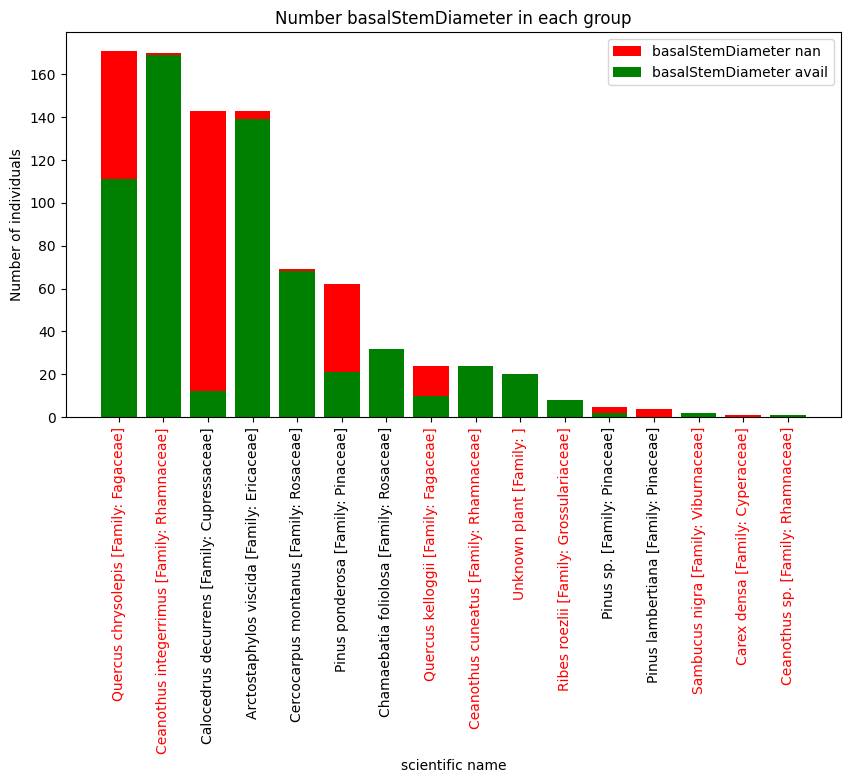

In [69]:
vegs = veg_df.scientificName.value_counts().to_dict()
def standardized_name(name):
    name = name.split()[:2]
    if name[-1] == 'sp.':
        name = name[0]
    else:
        name = ' '.join(name)
    return name

def avail_biomass_func(name):
    genus, n = name.split(' ')[:2]
    biomass_func = None
    if name == 'Unknown plant':
        pass
    elif genus in biomass_coeffs:
        biomass_func = biomass_coeffs[genus]
    else:
        if family_mapping[name] in biomass_coeffs:
            biomass_func = biomass_coeffs[family_mapping[name]]
    return biomass_func

result_biomass = []
for row in veg_df.itertuples():
    d = row.basalStemDiameter
    if not np.isnan(d):
        tree_name = row.scientificName
        genus, name = tree_name.split(' ')[:2]
        biomass_func = None
        if tree_name == 'Unknown plant':
            pass
        elif genus in biomass_coeffs:
            biomass_func = biomass_coeffs[genus]
        else:
            if family_mapping[tree_name] in biomass_coeffs:
                biomass_func = biomass_coeffs[family_mapping[tree_name]]

        if biomass_func:
            b1, b2 = biomass_func(d)
        
        biomass = cal_biomass(b1, b2, d)
        result_biomass.append(biomass)
    else:
        result_biomass.append(np.nan)

processed_vegs = {}
for k, v in vegs.items():
    processed_vegs[standardized_name(k)] = v

values = {}
groups = veg_df.groupby('scientificName')
for name, group in groups:
    nan_values = pd.isna(group.basalStemDiameter)
    values[name] = [np.sum(~nan_values), np.sum(nan_values)]

X = vegs.keys()
avail = np.array([values[i][0] for i in X])
nan = np.array([values[i][1] for i in X])

fig, axs = plt.subplots(figsize=(10, 5))
X_axis = np.arange(len(X))
plt.bar(X_axis, avail+nan, label='basalStemDiameter nan', color='red')
plt.bar(X_axis, avail, label='basalStemDiameter avail', color='green')
plt.xticks(X_axis, vegs.keys())
[label.set_color('red') for label in axs.xaxis.get_ticklabels() if not avail_biomass_func(label.get_text())]
plt.xticks(X_axis, [f"{' '.join(name.split()[:2])} [Family: {family_mapping[name]}]" for name in vegs.keys()])
plt.xticks(rotation = 90)
plt.xlabel("scientific name")
plt.ylabel("Number of individuals")
plt.title("Number basalStemDiameter in each group")
plt.legend()
plt.show()


In [73]:
total_avail_biomass_func = 0
total_avail = 0
for i in vegs.keys():
    total_avail += values[i][0]
    if avail_biomass_func(i):
        total_avail_biomass_func += values[i][0]
total_avail_biomass_func/total_avail

0.44264943457189015

In [37]:
exclude = ['Unknown plant']
result = []
for row in veg_df.itertuples():
    name = row.scientificName
    bs_area = row.basalStemDiameter
    if name in exclude:
        result.append(np.nan)
    else:
        if bs_area != np.nan:
            val = veg_df[veg_df.scientificName == name].basalStemDiameter.dropna().mean()
        else:
            val = veg_df[veg_df.scientificName == name].basalStemDiameter
        result.append(np.pi/4 * val**2)
result

[4.518351132658995,
 1.5289262342291958,
 1.5289262342291958,
 10.037879402071512,
 2.0106192982974664,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 1.5289262342291958,
 10.037879402071512,
 10.037879402071512,
 1.2867963509103788,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 1.2867963509103788,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 10.037879402071512,
 10.037879402071512,
 1.7671458676442586,
 1.7671458676442586,
 1.2867963509103788,
 10.037879402071512,
 10.037879402071512,
 1.2867963509103788,
 0.9503317777109126,
 0.9503317777109126,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 21.231290384407522,
 21.231290384407522,
 21.231290384407522,
 21.2312903844

In [6]:
veg_df[pd.isna(veg_df.basalStemDiameter)].scientificName.count()

260

In [10]:
result_biomass

[5.070813815035189,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.24664837210066257,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.1378225979280195,
 0.5153989507825852,
 0.1700260893419814,
 nan,
 nan,
 0.45235209027738993,
 0.10950336495665298,
 0.10950336495665298,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.5833150120415578,
 36.48424887961488,
 20.266057814936385,
 2.745485906309442,
 0.9994845561187614,
 5.852727905159767,
 8.947595227395889,
 10.404778627283909,
 37.282525110485054,
 19.70845487464643,
 1.813451343655655,
 0.3404318768009185,
 0.24664837210066257,
 0.3940667996832277,
 50.493675500672715,
 46.74072778425108,
 0.6562046278606125,
 1.813451343655655,
 2.923100054695927,
 17.055889001022383,
 9.660099420506524,
 9.660099420506524,
 23.19191596279373,
 6.998897455751004,
 8.266846572662233,
 11.182044698731158,
 1.953246955412628,
 1.2034765627453636,
 2.099159967306872,
 0.8173070621885032,
 3.6